## 데이터 및 평가 지표 불러오기

In [195]:
from datasets import load_from_disk

datasets = load_from_disk("resources/raw_data/decoder_data/train")

In [196]:
datasets

Dataset({
    features: ['ID', 'text', 'noise_added_text'],
    num_rows: 496
})

In [197]:
datasets['noise_added_text'][0]

'듀얼심 아이폰 %반기 출-설 솔솔…알뜰폰 *대감'

## Pre-trained 모델 및 토크나이저 불러오기

In [198]:
from transformers import AutoConfig,AutoModelForSeq2SeqLM,AutoTokenizer

In [209]:
model_name = "KETI-AIR/ke-t5-large"

In [200]:
config = AutoConfig.from_pretrained(
    model_name,
    cache_dir=None,
)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=None,
    use_fast=True,
)
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    config=config,
    cache_dir=None,
)

## 설정하기

In [201]:
def tokenize_count_function(examples):
    # Tokenize the 'cleaned_NSGREC' column and calculate the length of the tokens
    text_tokenized_length = [len(tokenizer.tokenize(text)) for text in examples['text']]
    noise_text_tokenized_length = [len(tokenizer.tokenize(text)) for text in examples['noise_added_text']]
    
    # Return the original examples with the new 'tokenized_length' column added
    examples["text_tokenized_length"] = text_tokenized_length
    examples["noise_text_tokenized_length"] = noise_text_tokenized_length
    
    return examples

In [202]:
tokenized_datasets=datasets.map(tokenize_count_function,batched=True)
print(tokenized_datasets)
print(tokenized_datasets[0])

Map:   0%|          | 0/496 [00:00<?, ? examples/s]

Dataset({
    features: ['ID', 'text', 'noise_added_text', 'text_tokenized_length', 'noise_text_tokenized_length'],
    num_rows: 496
})
{'ID': 'ynat-v1_train_00009', 'text': '듀얼심 아이폰 하반기 출시설 솔솔…알뜰폰 기대감', 'noise_added_text': '듀얼심 아이폰 %반기 출-설 솔솔…알뜰폰 *대감', 'text_tokenized_length': 14, 'noise_text_tokenized_length': 17}


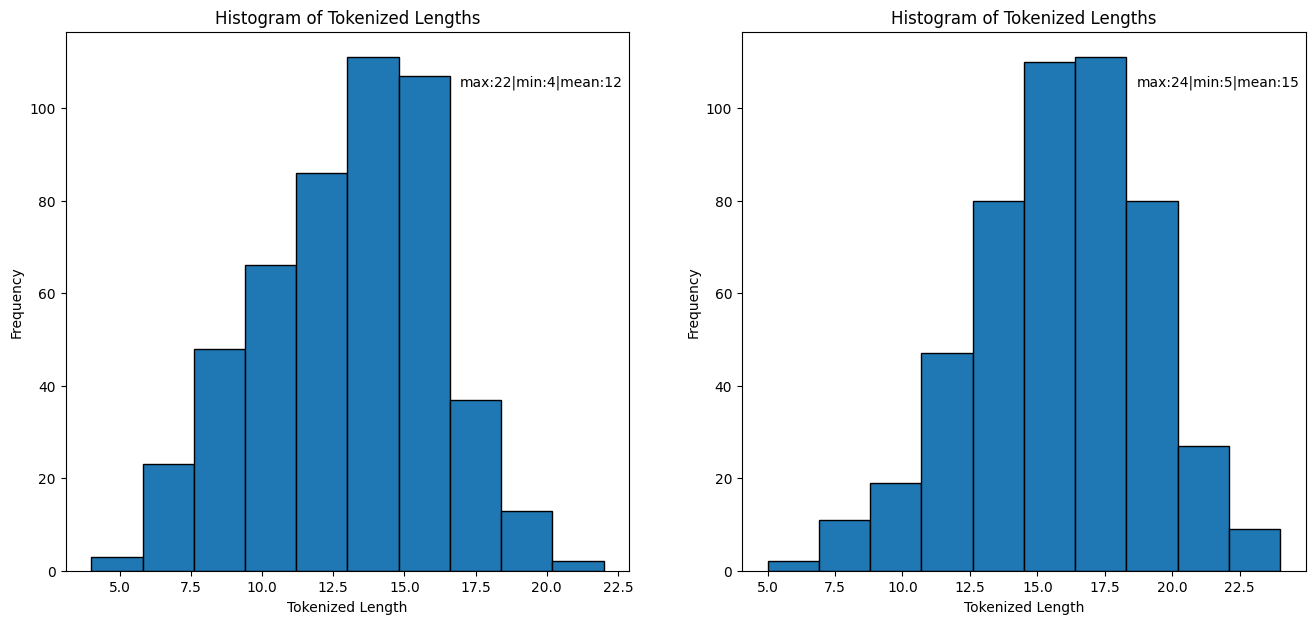

In [203]:
import matplotlib.pyplot as plt
import numpy as np

text_tokenized_length = tokenized_datasets['text_tokenized_length']
noise_text_tokenized_length = tokenized_datasets['noise_text_tokenized_length']

cleaned_Max=max(text_tokenized_length)
cleaned_Min=min(text_tokenized_length)
cleaned_Mean=np.mean(text_tokenized_length)

noise_Max=max(noise_text_tokenized_length)
noise_Min=min(noise_text_tokenized_length)
noise_Mean=np.mean(noise_text_tokenized_length)

fig,ax=plt.subplots(1,2,figsize=(16,7))
ax[0].hist(text_tokenized_length, bins=10, edgecolor='black')
ax[0].set_title('Histogram of Tokenized Lengths')
ax[0].set_xlabel('Tokenized Length')
ax[0].set_ylabel('Frequency')
plt.text(0.7, 0.9, f'max:{cleaned_Max}|min:{cleaned_Min}|mean:{int(cleaned_Mean)}', color='black', transform=ax[0].transAxes)

ax[1].hist(noise_text_tokenized_length, bins=10, edgecolor='black')
ax[1].set_title('Histogram of Tokenized Lengths')
ax[1].set_xlabel('Tokenized Length')
ax[1].set_ylabel('Frequency')
plt.text(0.7, 0.9, f'max:{noise_Max}|min:{noise_Min}|mean:{int(noise_Mean)}', color='black', transform=ax[1].transAxes)

plt.show()

In [204]:
max_source_length = 30
max_target_length = 30
padding = "max_length"
preprocessing_num_workers = 12
num_beams = 3
num_train_epochs = 5
train_batch_size = 64
eval_batch_size = 8
learning_rate = 5e-4

## 전처리하기

In [205]:
def preprocess_function(examples):
     # Using both 'noise_added_text' and 'text' together in the tokenizer call
    model_inputs = tokenizer(examples['noise_added_text'],
                             text_target=examples['text'],
                             max_length=max_source_length, 
                             truncation=True,
                             padding=padding, 
                             return_tensors='pt')
    
    return model_inputs


In [206]:
datasets=datasets.map(
            preprocess_function,
            batched=True,
            num_proc=preprocessing_num_workers,
            load_from_cache_file=False,
            remove_columns=datasets.column_names,
            )

Map (num_proc=12):   0%|          | 0/496 [00:00<?, ? examples/s]

In [207]:
datasets

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 496
})

In [208]:
print(tokenizer.decode(datasets[0]['input_ids']))
print(tokenizer.decode(datasets[0]['labels']))

<unk> <unk> %<unk> <unk>-<unk> <unk>...<unk> *<unk></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<unk> <unk> <unk> <unk> <unk>...<unk> <unk></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


## Fine-tuning하기

In [104]:
from transformers import (
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)

In [105]:
data_collator = DataCollatorForSeq2Seq(
            tokenizer,
            model=model,
        )

In [106]:
examples = data_collator(datasets)
examples.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [107]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [108]:
args = Seq2SeqTrainingArguments(
    output_dir='outputs',
    do_train=True,          # 학습은 진행
    do_eval=False,          # 평가를 진행하지 않음
    per_device_train_batch_size=train_batch_size,
    predict_with_generate=False,  # 예측을 생성하지 않음 (필요 없으므로 False로 설정)
    num_train_epochs=num_train_epochs,
    save_strategy = 'epoch',
    evaluation_strategy = 'no',   # 평가 전략을 'no'로 설정
    save_total_limit = 2,
    logging_strategy = 'epoch',
    load_best_model_at_end = False,  # 평가를 하지 않으므로 베스트 모델 로드 불필요
    learning_rate = learning_rate,
    remove_unused_columns = True,
    # report_to="none"
)


/data/ephemeral/home/kdh/level2-nlp-datacentric-nlp-08/.venv/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [109]:
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=datasets,
    # eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    # compute_metrics=compute_metrics,
)

/tmp/ipykernel_91244/917414707.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [110]:
train_result = trainer.train()

Step,Training Loss
8,28.342100
16,18.696400
24,14.360500
32,11.713900
40,10.752900


In [ ]:
import torch

text="프로야구~롯TKIAs광주 경기 y천취소"
# 듀얼심 아이폰 %반기 출-설 솔솔…알뜰폰 *대감


# 모델을 실행할 디바이스 설정 (GPU가 있으면 cuda로, 없으면 cpu로 설정)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 해당 디바이스로 이동
model.to(device)

# 입력 텍스트 토크나이징 및 디바이스로 이동
inputs = tokenizer(text, return_tensors="pt").to(device)


# 모델에 입력 넣기 (디코딩을 위한 예측 생성)
with torch.no_grad():  # 학습이 아니라 추론이므로 grad 계산 비활성화
    generated_ids = model.generate(inputs["input_ids"])
    
    
predicted_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
# print(generated_ids[0])
# print(predicted_text)


tensor([0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3],
       device='cuda:0')
<pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 


In [192]:
print(f"입력 텍스트: {text}")
print(f"모델의 예측: {predicted_text}")

입력 텍스트: 프로야구~롯TKIAs광주 경기 y천취소
모델의 예측:          


### **콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다. 모델 라이선스 : MIT License

